In [1]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from transformers import (SamModel, SamProcessor)

from step_2.utils import *

In [2]:
torch.manual_seed(0)
np.random.seed(0)

GPU = -1

device = torch.device("cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device).eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [47]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

input_points = [[[500, 600]]]

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)

In [5]:
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear, torch.nn.Conv2d},
    dtype=torch.qint8)

In [48]:
model_dynamic_quantized.eval()
with torch.no_grad():
    image_embeddings = model_dynamic_quantized.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    outputs = model_dynamic_quantized(**inputs)

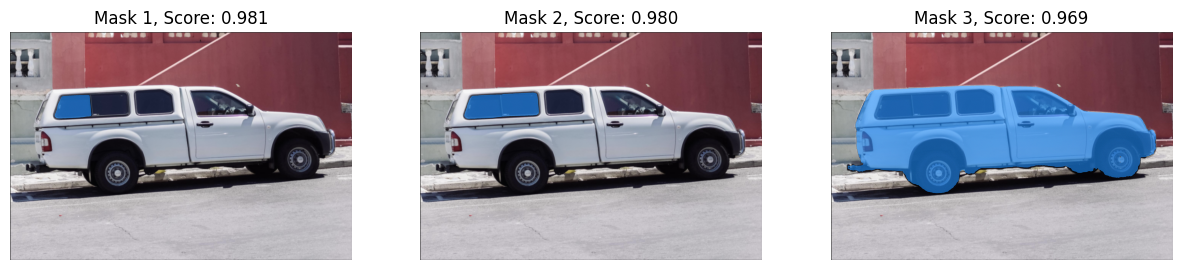

In [49]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [45]:
model.eval()
with torch.no_grad():
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    outputs = model(**inputs)

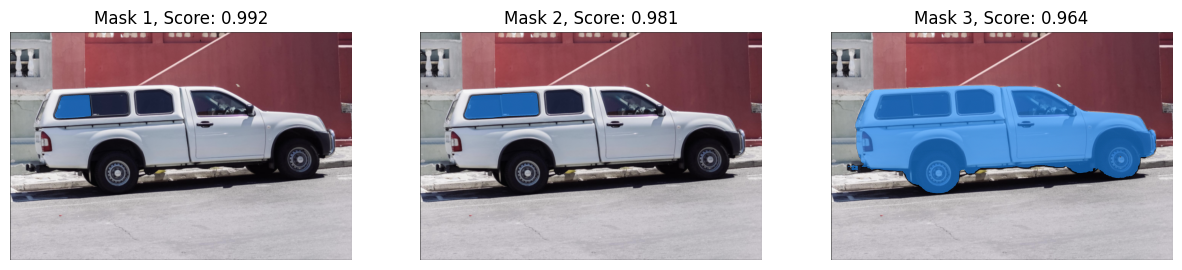

In [46]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [50]:
scripted_quantized_model = torch.jit.script(model_dynamic_quantized)
scripted_quantized_model.save("bin/sam_scripted_quantized.pt")

NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/home/sa58728/anaconda3/envs/sam/lib/python3.9/site-packages/transformers/models/sam/modeling_sam.py", line 1300
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs,
         ~~~~~~~ <--- HERE
    ) -> List[Dict[str, torch.Tensor]]:
        r"""
